0 Grad


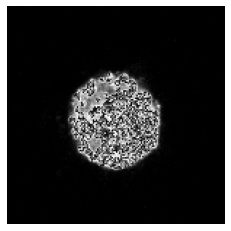

45 Grad


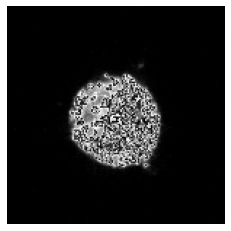

In [1]:
#Loading The Image
from tifffile import tifffile
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import rescale
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy.ndimage import  affine_transform
from scipy import ndimage as ndi
import cv2





def show(image, title="blank"):
    print(title)
    plt.axis("off")
    plt.imshow(image,cmap="gray")
    plt.show()
    
def zProjection(image3D):
    sumImage = image3D[0].copy()
    for i in range(1, len(image3D)):
        sumImage += image3D[i]
    return mmScale(sumImage)

def mmScale(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

path1 = r"C:\Users\danf\Desktop\Bachelor\Richter\Images - Axial Tomography\Bilder für Imhoff\2016-04-13 HeLa+Doxorubicin\002_HeLa_Doxo_4uM-27h_F_Angle000_STACK.tif"
volume1 = tifffile.imread(path1)
path2 = r"C:\Users\danf\Desktop\Bachelor\Richter\Images - Axial Tomography\Bilder für Imhoff\2016-04-13 HeLa+Doxorubicin\002_HeLa_Doxo_4uM-27h_F_Angle045_STACK.tif"
volume2 = tifffile.imread(path2)

show(zProjection(volume1),"0 Grad")
show(zProjection(volume2),"45 Grad")


In [2]:
# Extract Maximums Vol 1

def keypoints(volume, zScale):
    struElem=5
    keypointList = []
    for i in range(len(volume)):
        img = volume[i].copy()
        gray = np.float32(img)
        #threshold für background
        gray[gray <50] = 0
        # image_max is the dilation of im with a 20*20 structuring element
        # It is used within peak_local_max function
        image_max = ndi.maximum_filter(gray, size=struElem, mode='constant')

        # Comparison between image_max and im to find the coordinates of local maxima
        coordinates = peak_local_max(gray, min_distance=struElem)
        lC = len(coordinates)
        tempKey = np.ones((lC,3))*(i+1)*zScale
        tempKey[:,1:] = np.asarray(coordinates)[:]
        keypointList.append(tempKey)
    return keypointList

def makeList(x):
    return np.vstack([l for l in x])
        

zScale = 3.571428571428571
key1 = makeList(keypoints(volume1, zScale))
key2 = makeList(keypoints(volume2, zScale))

print("keypoints generated")
key1

keypoints generated


array([[  3.57142857,  72.        ,  67.        ],
       [  7.14285714,  70.        ,  67.        ],
       [  7.14285714,  81.        ,  64.        ],
       [ 10.71428571,  73.        ,  69.        ],
       [ 10.71428571,  79.        ,  65.        ],
       [ 10.71428571,  87.        ,  82.        ],
       [ 10.71428571,  64.        ,  74.        ],
       [ 10.71428571,  95.        ,  80.        ],
       [ 10.71428571,  81.        ,  74.        ],
       [ 14.28571429,  79.        ,  65.        ],
       [ 14.28571429,  86.        ,  82.        ],
       [ 14.28571429,  93.        ,  81.        ],
       [ 14.28571429,  74.        ,  57.        ],
       [ 14.28571429,  83.        ,  72.        ],
       [ 14.28571429,  91.        ,  89.        ],
       [ 14.28571429,  62.        ,  70.        ],
       [ 14.28571429,  73.        ,  91.        ],
       [ 14.28571429,  99.        ,  91.        ],
       [ 17.85714286,  88.        ,  63.        ],
       [ 17.85714286,  93.     

In [3]:
# Make Deskriptors
import scipy.spatial as sp

def normV(v):
    return 1/np.linalg.norm(v)*v

def desk(p0, points):
    #v1, v2, v3 = np.zeros((1,3)), np.zeros((1,3)), np.zeros((1,3))
    # p0 als ursprung
    pointsOrigin = points-p0
    #print(pointsOrigin)
    magnitudes = np.asarray([np.linalg.norm(p) for p in pointsOrigin])
    #print(magnitudes)
    sortArgs = np.argsort(magnitudes)[::-1]
    magnitudesSorted = magnitudes[sortArgs]
    pointsSorted = pointsOrigin[sortArgs]
    #print(pointsSorted)
    # Finden des neuen Systems
    v1 = pointsSorted[0]
    v2 = np.cross(pointsSorted[0],pointsSorted[2])
    v3 = np.cross(v1,v2)

    # Basistransformation
    ONB = np.array([[1,0,0],[0,1,0],[0,0,1]])
    neueBasis = np.array([v1,v2,v3])
    TransMat = np.dot(np.linalg.inv(neueBasis),ONB)
    vek1 = np.dot(TransMat, pointsSorted[1])
    vek2 = np.dot(TransMat, pointsSorted[2])
    #print(vek1,vek2)
    return np.hstack([vek1,vek2])

def makeDesc(keys):
    kdTree = sp.KDTree(keys)
    descriptorList = []
    for point in keys:
        disctances, pointIndices = kdTree.query(point,4)
#        print("point",point)
#         print("disctances",disctances)
#         print("pointIndices",pointIndices)
        try:
            desc = desk(point, keys[pointIndices[1:]])
            descriptorList.append(desc)
        except:
            print("Singular Matrix Error!")
            
    return descriptorList
        
desc1 = makeDesc(key1)
desc2 = makeDesc(key2)

print("Descriptors generated")
print(desc1)

Singular Matrix Error!
Singular Matrix Error!
Singular Matrix Error!
Singular Matrix Error!
Singular Matrix Error!
Singular Matrix Error!
Singular Matrix Error!
Singular Matrix Error!
Singular Matrix Error!
Descriptors generated
[array([ 0.24028923,  0.62111515, -0.23154831,  0.13121423,  0.3254588 ,
       -0.05789239]), array([ 0.09471134, -0.29330924,  0.21047405, -0.15779506,  0.17043008,
       -0.28361347]), array([ 0.24113054, -0.60537096,  0.28774179,  0.11577955, -0.32458476,
        0.11225042]), array([-0.05624523, -0.13613918,  0.2689454 ,  0.4894434 ,  0.10674091,
       -0.01566831]), array([ 0.00538462,  0.45516484, -0.21010989,  0.        , -0.41208791,
        0.27472527]), array([ 0.55330802,  0.40811153,  0.00911332,  0.39609039, -0.13699204,
        0.20173982]), array([-0.16163491,  0.32944337, -0.05539497,  0.2210659 , -0.26972342,
        0.05216126]), array([ 0.0050134 , -0.85664158,  0.14486227,  0.0050134 , -0.43647351,
        0.03982025]), array([-0.0109635 

In [4]:
# Match
from skimage.feature import match_descriptors
from scipy.spatial.distance import cdist

def slowMatch(descriptors1, descriptors2):
    distances = cdist(descriptors1, descriptors2, metric="euclidean")
    indices1 = np.arange(descriptors1.shape[0])
    indices2 = np.argmin(distances, axis=1)
    matches = np.column_stack((indices1, indices2))

    return matches

desc1 = np.asarray(desc1)
desc2 = np.asarray(desc2)

matches = slowMatch(desc1, desc2)
matches

array([[  0,  58],
       [  1, 177],
       [  2,  46],
       [  3,  41],
       [  4, 103],
       [  5,   0],
       [  6, 123],
       [  7, 178],
       [  8, 161],
       [  9, 184],
       [ 10,  84],
       [ 11, 220],
       [ 12, 274],
       [ 13, 108],
       [ 14,  16],
       [ 15, 268],
       [ 16, 283],
       [ 17, 273],
       [ 18,  71],
       [ 19, 229],
       [ 20,  85],
       [ 21, 267],
       [ 22,  85],
       [ 23, 192],
       [ 24, 159],
       [ 25, 181],
       [ 26, 160],
       [ 27, 117],
       [ 28, 277],
       [ 29,   0],
       [ 30, 126],
       [ 31, 192],
       [ 32,  77],
       [ 33,  72],
       [ 34,  52],
       [ 35, 273],
       [ 36, 265],
       [ 37, 212],
       [ 38,  85],
       [ 39,  73],
       [ 40,   5],
       [ 41, 268],
       [ 42, 154],
       [ 43, 111],
       [ 44, 103],
       [ 45,  91],
       [ 46,  26],
       [ 47,  47],
       [ 48,  68],
       [ 49, 171],
       [ 50, 231],
       [ 51, 221],
       [ 52,

In [7]:
# RANSAC
def expand(x):
    newX = np.ones((len(x),4))
    newX[:,:3] = x
    return newX

def transform(model, points):
    transPoints = []
    for point in points:
        tP = np.dot(point, np.linalg.inv(model))
        transPoints.append(tP)
    return np.asarray(transPoints)

def distance(pointA, pointB, metric='euclidean'):
    distance = 0
    if metric == 'euclidean':
        try:
            distance =  np.sqrt((pointA[0]-pointB[0])**2+ + \
                                (pointA[1]-pointB[1])**2+  + \
                                (pointA[2]-pointB[2])**2)
        except:
            print(pointA)
            print(pointB)
    else:
        print(f"Metric {metric} is not implemented. Try euclidean.")
    return distance

def ransac(matches, keypointsA, keypointsB, iterations=100, samples=10, epsilon=5):
    inlierList = []
    modelList = []
    for i in range(iterations):
        # 1. generate Random Subset
        subIndexes = np.random.permutation(len(matches))[:samples]
#         print(subIndexes)
#         print(matches[subIndexes])
#         print(matches[subIndexes,0])
        subPointsA = keypointsA[matches[subIndexes,0]]
        subPointsB = keypointsB[matches[subIndexes,1]]
#         print(subPointsA)
#         print(subPointsB)
        # 2. model with subset
        model = np.linalg.lstsq(subPointsA, subPointsB, rcond=None)[0]
        #print(np.round(model,2))
        # 3. count number of inliers within tollerance epsilon
        inliers = 0
        transPointsB = transform(model, keypointsB)
        for match in matches:
#             print(match)
#             print(match[0],match[1])
#             print(keypointsA[match[0]])
#             print(transPointsB[match[1]])
            dist = distance(keypointsA[match[0]],transPointsB[match[1]],'euclidean')
            if dist < epsilon:
                inliers += 1
        inlierList.append(inliers)
        modelList.append(model)
    #4. chose model with the most inliers
    print(inlierList)
    print(f"The best model is model {np.argmax(inlierList[:])}.")
    print(f"It has  {inlierList[np.argmax(inlierList[:])]} inlyers.")
    bestModel = modelList[np.argmax(inlierList[:])]
    #5. generate a model with all the inliers
    chosenInliersA = []
    chosenInliersB = []
    for match in matches:
            dist = distance(keypointsA[match[0]],transPointsB[match[1]],'euclidean')
            if dist < epsilon:
                chosenInliersA.append(keypointsA[match[0]])  
                chosenInliersB.append(keypointsB[match[1]])
    chosenInliersA, chosenInliersB = np.asarray(chosenInliersA), np.asarray(chosenInliersB)
    print(chosenInliersA.shape)
    refinedModel = np.linalg.lstsq(chosenInliersA, chosenInliersB, rcond=None)[0]
    return refinedModel

key1Exp = expand(key1)
key2Exp = expand(key2)
out = ransac(matches, key1Exp, key2Exp, iterations=100, samples=4, epsilon=10)
out

[4, 7, 0, 4, 6, 5, 8, 10, 4, 7, 10, 6, 9, 8, 4, 1, 0, 5, 4, 4, 6, 5, 4, 4, 7, 5, 6, 6, 1, 6, 8, 4, 7, 5, 6, 5, 1, 8, 8, 8, 0, 4, 5, 6, 6, 5, 10, 4, 9, 9, 4, 4, 6, 4, 6, 4, 4, 4, 6, 4, 4, 6, 6, 1, 0, 5, 4, 6, 10, 5, 0, 4, 4, 5, 5, 4, 12, 4, 6, 4, 6, 4, 5, 5, 8, 0, 7, 12, 0, 4, 11, 4, 4, 5, 5, 6, 6, 7, 5, 9]
The best model is model 76.
It has  12 inlyers.
(9, 4)


array([[-4.45576276e-01,  5.27867324e-01, -3.48713122e+00,
        -9.42914606e-19],
       [ 4.52464539e-01, -4.23295471e-01,  1.05690032e+00,
         3.46944695e-18],
       [-3.76957956e-01,  1.05313121e+00, -1.54486513e+00,
         2.76938326e-18],
       [ 6.04401838e+01,  7.12092263e+00,  2.89832152e+02,
         1.00000000e+00]])

zFactor:  3.571428571428571
shape:  (82, 150, 150)
size:  150
matrix: 
 [[-4.45576276e-01  4.52464539e-01 -3.76957956e-01  6.04401838e+01]
 [ 5.27867324e-01 -4.23295471e-01  1.05313121e+00  7.12092263e+00]
 [-3.48713122e+00  1.05690032e+00 -1.54486513e+00  2.89832152e+02]
 [-9.42914606e-19  3.46944695e-18  2.76938326e-18  1.00000000e+00]]
newMatrix: 
 [[ -0.44557628   0.45246454  -0.37695796  60.4401838 ]
 [  0.52786732  -0.42329547   1.05313121   7.12092263]
 [ -3.48713122   1.05690032  -1.54486513 289.83215187]
 [  0.           0.           0.           1.        ]]
0 Grad


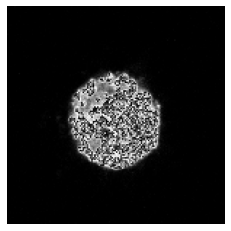

45 Grad


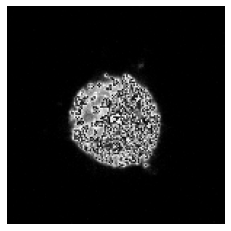

45 Grad transformiert


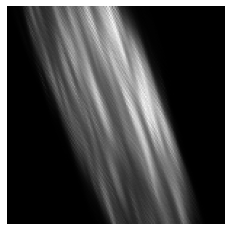

In [12]:
# Show Transfomation
from scipy.ndimage import  affine_transform
from skimage.transform import rescale


def realSize(volume, z, xy):
    xFactor = 1.
    yFactor = 1.
    zFactor = z/xy
    print("zFactor: ",zFactor)
    resizedVolume = rescale(volume, (zFactor, yFactor, xFactor), mode='reflect')
    return resizedVolume

def applyTrans(volume, matrix):
    size = np.max(volume.shape)
    print("shape: ", volume.shape)
    print("size: ", size)
    print("matrix: \n", matrix)
    newMatrix = np.vstack([matrix[:3],np.asarray([0,0,0,1])])
    print("newMatrix: \n", newMatrix)
    # zentrumsmatrix
    shiftX, shiftY, shiftZ  = int(volume.shape[0]/2), int(volume.shape[1]/2), int(volume.shape[2]/2)
    MshiftCenter = np.float32([[1,0,0,shiftX],[0,1,0,shiftY],[0,0,1,shiftZ],[0,0,0,1]])

#     rotX, rotY, rotZ  = np.radians(0),np.radians(0),np.radians(angle)
#     MrotX = np.float32([[1,0,0,0],[0,np.cos(rotX),np.sin(rotX),0],[0,-1*np.sin(rotX),np.cos(rotX),0],[0,0,0,1]])
#     MrotY = np.float32([[np.cos(rotY),0,-np.sin(rotY),0],[0,1,0,0],[np.sin(rotY),0,np.cos(rotY),0],[0,0,0,1]])
#     MrotZ = np.float32([[np.cos(rotZ),-np.sin(rotZ),0,0],[np.sin(rotZ),np.cos(rotZ),0,0],[0,0,1,0],[0,0,0,1]])

    MshiftBack = np.float32([[1,0,0,-shiftX],[0,1,0,-shiftY],[0,0,1,-shiftZ],[0,0,0,1]])

    M = np.linalg.multi_dot([MshiftCenter,newMatrix,MshiftBack])
#    M = np.linalg.multi_dot([MshiftCenter,np.linalg.inv(newMatrix),MshiftBack])

    #print(M)
    rotatedVolume = affine_transform(volume,
                                   newMatrix,
                                   offset=0.0,
                                   order=1,
                                   mode='constant',
                                   cval=0,
                                   prefilter=True)
    return rotatedVolume


newVol = applyTrans(realSize(volume2,1.0,0.28), out.T)

show(zProjection(volume1[1:]),"0 Grad")
show(zProjection(volume2[1:]),"45 Grad")
show(zProjection(newVol),"45 Grad transformiert")

In [13]:
# Extraktion der Euler Parameter aus out
from scipy.spatial.transform import Rotation as R

print("matrix: \n", out.T)
print("only rot: \n", out.T[:-1,:-1])
r = R.from_matrix(out.T[:-1,:-1])
r.as_euler('zyx', degrees=True)

matrix: 
 [[-4.45576276e-01  4.52464539e-01 -3.76957956e-01  6.04401838e+01]
 [ 5.27867324e-01 -4.23295471e-01  1.05313121e+00  7.12092263e+00]
 [-3.48713122e+00  1.05690032e+00 -1.54486513e+00  2.89832152e+02]
 [-9.42914606e-19  3.46944695e-18  2.76938326e-18  1.00000000e+00]]
only rot: 
 [[-0.44557628  0.45246454 -0.37695796]
 [ 0.52786732 -0.42329547  1.05313121]
 [-3.48713122  1.05690032 -1.54486513]]


array([ 92.88819956,  68.05166252, -35.76620274])